Author: Stephen Tukor, Zikang Ge

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

In [ ]:
train_data = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Training.xlsx") # Read training data set
test_data = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Test.xlsx") # Read testing data set

# Data Pre-processing

In [ ]:
# Rename test data columns to match train data
test_data.rename(columns={
    'ANNUALKM': 'ANNUAL_KM',
    'COMMUTEDISTANCE': 'COMMUTE_DISTANCE',
    'MARKINGSYSTEM': 'MARKING_SYSTEM',
    'TRACKINGSYSTEM': 'TRACKING_SYSTEM',
    'VEHICLEOWNERSHIP': 'VEHICLE_OWNERSHIP',
    'VEHICLEVALUE': 'VEHICLE_VALUE',
    'YEAROFBIRTH': 'YEAR_OF_BIRTH',
    'POSTALCODE': 'POSTAL_CODE',
    'AREACODE': 'AREA_CODE',
    'YEARSLICENSED': 'YEARS_LICENSED',
    'YEARSASPRINCIPALDRIVER': 'YEARS_AS_PRINCIPAL_DRIVER',
    'MULTIPRODUCT': 'MULTI_PRODUCT',
    'MARITALSTATUS': 'MARITAL_STATUS',
    'CONVICTIONCOUNTMINOR3YRS': 'CONVICTION_COUNT_MINOR_3YRS',
    'CONVICTIONCOUNTMAJOR3YRS': 'CONVICTION_COUNT_MAJOR_3YRS',
    'CONVICTIONCOUNTCRIMINAL3YRS': 'CONVICTION_COUNT_CRIMINAL_3YRS',
    'ASSIGNEDLOSSESPD5YRS': 'ASSIGNED_LOSSES_PD_5YRS',
    'SUSPENSIONCOUNT': 'SUSPENSION_COUNT',}, inplace=True)

In [ ]:
# Check data type of each variable
print(train_data.dtypes)

QUOTEDATE                         datetime64[ns]
VEHICLEYEAR                                int64
VEHICLEMAKE                               object
VEHICLEMODEL                              object
ANNUAL_KM                                float64
COMMUTE_DISTANCE                         float64
MARKING_SYSTEM                            object
TRACKING_SYSTEM                           object
VEHICLE_OWNERSHIP                         object
VEHICLE_VALUE                            float64
VEHICLEUSE                                object
GENDER                                    object
YEAR_OF_BIRTH                              int64
POSTAL_CODE                               object
AREA_CODE                                 object
YEARS_LICENSED                           float64
YEARS_AS_PRINCIPAL_DRIVER                float64
MULTI_PRODUCT                             object
MARITAL_STATUS                            object
OCCUPATION                                object
CONVICTION_COUNT_MIN

In [ ]:
# Check for NA values in each column
for column in train_data.columns:
    if train_data[column].isna().sum() > 0:
        print(f"{column} has {train_data[column].isna().sum()} missing values.")
print("")
for column in test_data.columns:
    if test_data[column].isna().sum() > 0:
        print(f"{column} has {test_data[column].isna().sum()} missing values.")

ANNUAL_KM has 1 missing values.
COMMUTE_DISTANCE has 35413 missing values.
MARKING_SYSTEM has 101866 missing values.
TRACKING_SYSTEM has 101887 missing values.
VEHICLE_OWNERSHIP has 76450 missing values.
VEHICLE_VALUE has 64673 missing values.
GENDER has 5 missing values.
YEARS_LICENSED has 8 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 101279 missing values.
OCCUPATION has 1 missing values.

COMMUTE_DISTANCE has 5191 missing values.
MARKING_SYSTEM has 15095 missing values.
TRACKING_SYSTEM has 15112 missing values.
VEHICLE_OWNERSHIP has 11500 missing values.
VEHICLE_VALUE has 10159 missing values.
YEARS_LICENSED has 3 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 14946 missing values.


## Data Cleaning

In [ ]:
# Combine train data and test data, will split them in the end
train_data['is_train'] = 1
test_data['is_train'] = 0

combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
# QUOTEDATE
combined_data['QUOTEDATE'] = pd.to_datetime(combined_data['QUOTEDATE'])
combined_data['Quote_Month'] = combined_data['QUOTEDATE'].dt.month

combined_data = pd.get_dummies(combined_data, columns=['Quote_Month'], prefix='Month')

This will drop the `QUOTEDATE` Column and change it into 12 columns, each one represents a month, I'm trying to find the pattern among months since the 100k rows of data are all within a year.

For now, the columns "Month_1", "Month_2", ..., "Month_12" are all booleans, I will convert them to 0s and 1s later.

In [ ]:
# VEHICLEYEAR

# Group by vehicle age brackets
def vehicle_age_group(year):
    if year < 1980:
        return 'Vintage'
    elif year < 2000:
        return 'Old'
    else:
        return 'Modern'

combined_data['Vehicle_Age_Group'] = combined_data['VEHICLEYEAR'].apply(vehicle_age_group)
combined_data = pd.get_dummies(combined_data, columns=['Vehicle_Age_Group'], prefix='Age')

# One-Hot Encoding for decades
combined_data['Vehicle_Decade'] = (combined_data['VEHICLEYEAR'] // 10) * 10
combined_data = pd.get_dummies(combined_data, columns=['Vehicle_Decade'], prefix='Decade')

This will categorize the column "VEHICLEYEAR" into three categoreis, then one-hot encode them. And then I categorize the original columns to decades, still one-hot encode them, trying to find patterns between decades.

In [ ]:
# VEHICLEMAKE
luxury_brands = ['BENZ', 'BMW', 'AUDI', 'BENTLEY', 'LEXUS', 'ROLLS ROYCE', 'ASTON MARTIN', 'CADILLAC', 'LAND ROVER', 'PORSCHE', 'ACURA', 'FERRARI', 'JAGUAR', 'LAMBORGHINI', 'TESLA', 'ALFA ROMEO', 'INFINITI', 'LINCOLN', 'MASERATI', 'GENESIS', 'VOLVO', 'BUGATTI', 'MAYBACH', 'MCLAREN']

luxury_pattern = re.compile('|'.join(luxury_brands), re.IGNORECASE)

# Apply the regex to categorize as 'Luxury' or 'Non-Luxury'
combined_data['car_category'] = combined_data['VEHICLEMAKE'].apply(
    lambda x: 'Luxury' if luxury_pattern.search(x) else 'Non-Luxury'
)

# Convert the 'car_category' column into dummy variables
combined_data = pd.get_dummies(combined_data, columns=['car_category'], prefix='car')

In [ ]:
# ANNUAL_KM
combined_data = combined_data[~combined_data['ANNUAL_KM'].isna()]

In [ ]:
# COMMUTE_DISTANCE
filtered_commute_distance = combined_data[combined_data['COMMUTE_DISTANCE'] < 120]['COMMUTE_DISTANCE']

median_commute_distance = filtered_commute_distance.median()
combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].fillna(median_commute_distance)

In [ ]:
# MARKING_SYSTEM
combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['MARKING_SYSTEM'], prefix='Marking')

<ipython-input-208-219f83f78459>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)


In [ ]:
# TRACKING_SYSTEM
combined_data['TRACKING_SYSTEM'].fillna("None", inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['TRACKING_SYSTEM'], prefix='Tracking')

<ipython-input-209-60bb88367a75>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['TRACKING_SYSTEM'].fillna("None", inplace=True)


In [ ]:
# VEHICLE_OWNERSHIP
combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['VEHICLE_OWNERSHIP'], prefix='Marking')

<ipython-input-210-e134d4629409>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)


In [ ]:
# VEHICLE_VALUE
mean_vehicle_value = combined_data[combined_data["VEHICLE_VALUE"]>5000]["VEHICLE_VALUE"].mean()
combined_data["VEHICLE_VALUE"].fillna(mean_vehicle_value, inplace=True)
combined_data.loc[combined_data["VEHICLE_VALUE"] < 5000, "VEHICLE_VALUE"] = mean_vehicle_value

<ipython-input-211-3dfb88927184>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data["VEHICLE_VALUE"].fillna(mean_vehicle_value, inplace=True)


In [ ]:
# VEHICLEUSE
combined_data = pd.get_dummies(combined_data, columns=['VEHICLEUSE'], prefix='VEHICLEUSE')

In [ ]:
# GENDER
combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['GENDER'], prefix='GENDER')

<ipython-input-213-be00d792cc21>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)


In [ ]:
# YEAR_OF_BIRTH
combined_data['YEAR_OF_BIRTH'] = (combined_data['YEAR_OF_BIRTH'] // 10) * 10
combined_data = pd.get_dummies(combined_data, columns=['YEAR_OF_BIRTH'], prefix='Year_Birth_Decade')

In [ ]:
# YEARS_LICENSED
mean_years_licensed = combined_data["YEARS_LICENSED"].mean()
combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)

<ipython-input-215-bb567306eb84>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)


In [ ]:
# MULTI_PRODUCT, MARITAL_STATUS
combined_data = pd.get_dummies(combined_data, columns=['MULTI_PRODUCT', 'MARITAL_STATUS'], prefix='MULTI_PRODUCT')

In [ ]:
# OCCUPATION
combined_data['OCCUPATION'].fillna("Not Known", inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['OCCUPATION'], prefix='OCCUPATION')

<ipython-input-217-4dc913ac1355>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['OCCUPATION'].fillna("Not Known", inplace=True)


In [ ]:
# Replace Bools with 0s and 1s
for col in combined_data.columns:
    if isinstance(combined_data[col], pd.Series) and combined_data[col].dtype == 'bool':
        combined_data[col] = combined_data[col].astype(int)

In [ ]:
# Split train data and test data
train_data = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train'])
test_data = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'IS_BOUND'])

## Standardization

In [ ]:
scaler = StandardScaler()

train_data_standardized = scaler.fit_transform(train_data.drop(columns=['IS_BOUND', 'QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']))
train_data_standardized = pd.DataFrame(train_data_standardized, columns=train_data.drop(columns=['IS_BOUND', 'QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']).columns)
train_data_standardized['IS_BOUND'] = train_data['IS_BOUND'].values  # Reattach "IS_BOUND" column

test_data_standardized = scaler.transform(test_data.drop(columns=['QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']))
test_data_standardized = pd.DataFrame(test_data_standardized, columns=test_data.drop(columns=['QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']).columns)


# Modelling Method 1 - Logistic Regression

## Logistic Regression 1

Accuracy: 0.5608008636765139
Confusion Matrix:
 [[8728 7268]
 [1682 2700]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.55      0.66     15996
         1.0       0.27      0.62      0.38      4382

    accuracy                           0.56     20378
   macro avg       0.55      0.58      0.52     20378
weighted avg       0.72      0.56      0.60     20378

AUC-ROC Score: 0.6140633458227633
F1 Score: 0.37630662020905925


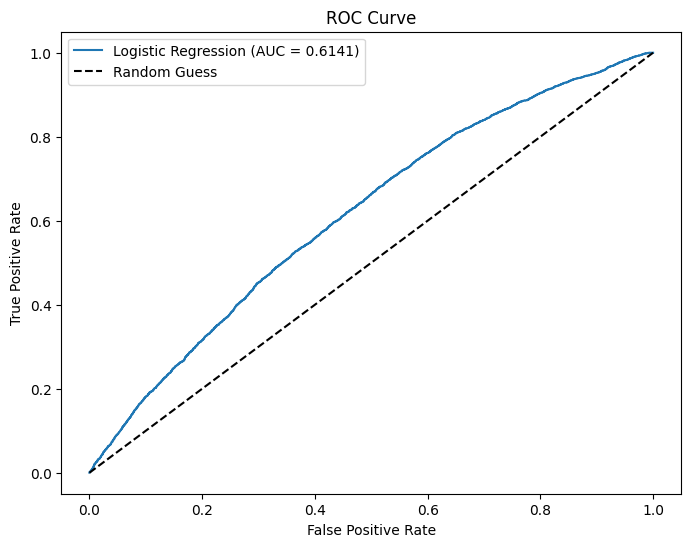

In [ ]:
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

# Calculate ROC curve values: FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calculate AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_proba)
print("AUC-ROC Score:", auc_score)
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Model Tuning

In [ ]:
def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]


    matrix = confusion_matrix(y_test, y_pred)
    accuracyScore = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = TP * 5.5 + (FP + TP) * -1

    return accuracyScore, auc_score, f1, profit

### Forward Selection

In [ ]:
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']
selected_features = []
remaining_features = X.columns.tolist()
best_auc = 0.5

while remaining_features:
    best_feature = None
    for feature in remaining_features:
        # Create a model with the current selected features plus the new candidate
        model = LogisticRegression()
        current_features = selected_features + [feature]

        # Evaluate model's precision using cross-validation
        accuracyScore, auc_score, f1, profit = log_reg(X[current_features], y)

        # Check if this precision is the best we've seen
        if auc_score > best_auc:
            best_auc = auc_score
            best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"Added feature: {best_feature} with auc: {auc_score}")
    else:
        break  # No more features improve precision

print("Selected features:", selected_features)

Added feature: MULTI_PRODUCT_No with auc: 0.5007204562436821
Added feature: Year_Birth_Decade_1980 with auc: 0.565485164079701
Added feature: VEHICLEYEAR with auc: 0.5894716633288857
Added feature: Year_Birth_Decade_1990 with auc: 0.5966262146892269
Added feature: Year_Birth_Decade_1970 with auc: 0.6023831166029755
Added feature: YEARS_LICENSED with auc: 0.6040459581463142
Added feature: OCCUPATION_Not Known with auc: 0.6091909216464317
Added feature: Year_Birth_Decade_9990 with auc: 0.6103825491402517
Added feature: Year_Birth_Decade_1940 with auc: 0.6112071434106816
Added feature: OCCUPATION_Office/Stores with auc: 0.6118204300048083
Added feature: MULTI_PRODUCT_Separated with auc: 0.612330605757327
Added feature: VEHICLEUSE_Pleasure with auc: 0.6128239756196465
Added feature: Year_Birth_Decade_1930 with auc: 0.6132490876027998
Added feature: CONVICTION_COUNT_CRIMINAL_3YRS with auc: 0.6137072763740913
Added feature: VEHICLEUSE_Farm Pleasure with auc: 0.6140950672971757
Added feature:

### Interaction Terms

In [ ]:
X_interact = train_data_standardized[selected_features]
y = train_data_standardized['IS_BOUND']
highest_auc = 0.6141
for i in X_interact.columns:
    for j in X_interact.columns:
        joint_feature_name = f'{i}_{j}'
        X_temp = X_interact.copy()  # Work on a copy of the best feature set
        X_temp[joint_feature_name] = X_interact[i] * X_interact[j]  # Create the joint feature
        X_temp.drop(columns=[i, j], inplace=True)  # Remove the original features
        accuracyScore, auc_score, f1, profit = log_reg(X_temp, y)

        # If the auc improves, keep the joint feature
        if auc_score > highest_auc:
            highest_auc = auc_score
            X_interact[joint_feature_name] = X_temp[i] * X_temp[j]
            print(f"New highest AUC with {joint_feature_name}: {highest_auc}")
        else:
            print(f"No improvement with {joint_feature_name}, skipping.")
            X_temp.drop(columns=[joint_feature_name], inplace=True)  # Remove the joint feature

log_reg(X_interact, Y)

KeyError: 'MULTI_PRODUCT_No'

### Threshold

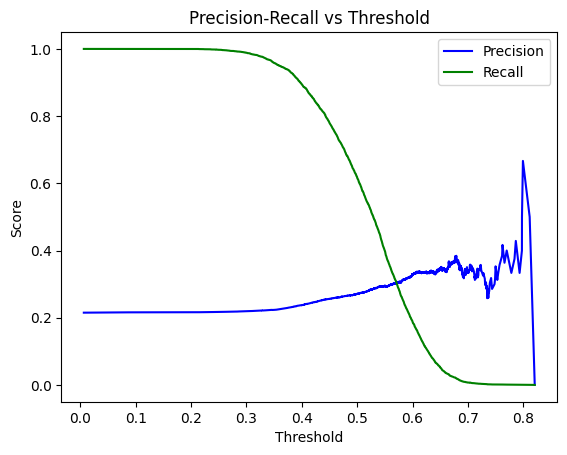

In [ ]:
X = X_interact
y = train_data_standardized['IS_BOUND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
# Profit for true positives(TP): +5.5
# Cost for predicting a positive(1): -1


y_pred_prob = model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.4, 0.5, 0.01)  # Adjust granularity if needed

#Evaluate performance at each threshold
for threshold in thresholds:
    # Predict class labels based on the threshold
    y_pred_custom = (y_pred_prob >= threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    auc = roc_auc_score(y_test, y_pred_custom)  # AUC remains the same, independent of threshold

    matrix = confusion_matrix(y_test, y_pred_custom)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = TP * 5.5 + (FP + TP) * -1
    # Print or store the metrics for each threshold
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, AUC-ROC: {auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
    print(f"Total Profit: {profit}")
    print("-" * 30)

Threshold: 0.40
Precision: 0.238, Recall: 0.894, F1-Score: 0.375, AUC-ROC: 0.554
Confusion Matrix:
 [[ 3418 12578]
 [  463  3919]]
Total Profit: 5057.5
------------------------------
Threshold: 0.41
Precision: 0.241, Recall: 0.875, F1-Score: 0.378, AUC-ROC: 0.561
Confusion Matrix:
 [[ 3938 12058]
 [  547  3835]]
Total Profit: 5199.5
------------------------------
Threshold: 0.42
Precision: 0.246, Recall: 0.854, F1-Score: 0.381, AUC-ROC: 0.568
Confusion Matrix:
 [[ 4501 11495]
 [  641  3741]]
Total Profit: 5339.5
------------------------------
Threshold: 0.43
Precision: 0.249, Recall: 0.831, F1-Score: 0.383, AUC-ROC: 0.573
Confusion Matrix:
 [[ 5020 10976]
 [  739  3643]]
Total Profit: 5417.5
------------------------------
Threshold: 0.44
Precision: 0.254, Recall: 0.809, F1-Score: 0.386, AUC-ROC: 0.579
Confusion Matrix:
 [[ 5566 10430]
 [  835  3547]]
Total Profit: 5531.5
------------------------------
Threshold: 0.45
Precision: 0.256, Recall: 0.780, F1-Score: 0.386, AUC-ROC: 0.580
Conf